In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd

import ROOT, uproot

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn import decomposition

# import necessary keras modules/functions
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import backend as K

from pickle import dump

from time import time

In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

Welcome to JupyROOT 6.18/04


Using TensorFlow backend.
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [3]:
def upsample(sample, scale):
    '''
    This function takes the sample and concatantes the same sample n times.
    '''
    if scale > 0:
        sample = np.vstack([sample]*scale)
    else:
        sample = sample
    return sample

from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    plt.style.use('seaborn')
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [4]:
import keras
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 36} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

2021-03-02 13:23:08.011985: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-03-02 13:23:08.021541: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2021-03-02 13:23:08.055503: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-03-02 13:23:08.055595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pauli
2021-03-02 13:23:08.055616: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pauli
2021-03-02 13:23:08.055772: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.102.4
2021-03-02 13:23:08.055817: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported

In [5]:
input_branches = ['br_njets', 'br_nbjets', 'br_scalar_ht',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_met',
       'br_met_phi', 'br_sphericity', 'br_aplanarity', 'br_fox_wolfram_1',
       'br_fox_wolfram_2', 'br_fox_wolfram_3', 'br_fox_wolfram_4']

df_signal = uproot.open("/mnt/harddisk4/scratch/signal_dtG3_flat.root")["outtree"].pandas.df(input_branches)
df_dyjets = uproot.open("/mnt/harddisk4/scratch/dyjets_flat_30M.root")["outtree"].pandas.df(input_branches)
df_wjets  = uproot.open("/mnt/harddisk4/scratch/wjets_flat_60M.root")["outtree"].pandas.df(input_branches)
df_single_top  = uproot.open("/mnt/harddisk4/scratch/single_top_merged_flat.root")["outtree"].pandas.df(input_branches)
print(df_signal.keys())
#print("n_signal:", len(df_signal), "n_dyjets:", len(df_dyjets), "n_wjets:", len(df_wjets), "n_single_top", len(df_single_top))

Index(['br_njets', 'br_nbjets', 'br_scalar_ht', 'br_jet_pt_1', 'br_jet_pt_2',
       'br_jet_pt_3', 'br_jet_pt_4', 'br_met', 'br_met_phi', 'br_sphericity',
       'br_aplanarity', 'br_fox_wolfram_1', 'br_fox_wolfram_2',
       'br_fox_wolfram_3', 'br_fox_wolfram_4'],
      dtype='object')


In [6]:
df_wjets.shape

(608, 15)

In [7]:
x_signal = df_signal.values
y_signal = np.full(len(x_signal) , 1)
print("number of signal events:%d" % (len(x_signal)))

x_dyjets = df_dyjets.values
x_wjets  = df_wjets.values
x_single_top  = df_single_top.values

#x_wjets  = upsample(x_wjets,  int((len(x_signal)/len(x_wjets))))
x_dyjets = upsample(x_dyjets, int((len(x_signal)/len(x_dyjets))))
x_wjets  = upsample(x_wjets, int((len(x_signal)/len(x_wjets))))
idx_max = int(0.5*len(x_signal))
x_bkg    = np.concatenate((x_dyjets[0:idx_max], x_wjets[0:idx_max], x_single_top[0:idx_max]), axis=0)
#x_bkg    = np.concatenate((x_dyjets[0:idx_max], x_single_top[0:idx_max]), axis=0)

#x_bkg    = x_single_top[0:idx_max]
y_bkg    = np.full(len(x_bkg) , 0)
print(idx_max)

number of signal events:206162
103081


In [8]:
x_sig_train, x_sig_test, y_sig_train, y_sig_test = train_test_split(x_signal, y_signal, test_size=0.5, random_state=20)
x_bkg_train, x_bkg_test, y_bkg_train, y_bkg_test = train_test_split(x_bkg, y_bkg, test_size=0.5, random_state=20)

x_train = np.concatenate((x_sig_train, x_bkg_train), axis=0)
y_train = np.concatenate((y_sig_train, y_bkg_train), axis=0)

x_test = np.concatenate((x_sig_test, x_bkg_test), axis=0)
y_test = np.concatenate((y_sig_test, y_bkg_test), axis=0)
                                  
scaler  = preprocessing.StandardScaler().fit(np.concatenate((x_train, x_test), axis=0))
dump(scaler, open('scaler.pkl', 'wb'))
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [9]:
print("training for", len(x_train), "events;", "testing for",  len(x_test), "events")

training for 257702 events; testing for 257703 events


In [30]:
def simple_model():
    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1,  activation='sigmoid', name="output_layer"))
    opt  = keras.optimizers.Adam(lr=0.00146)
    loss = keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    return model

def dnn_model(x_tr, y_tr, x_ts, y_ts, callbacks, params):
    
    model = Sequential()
    
    model.add(Dense(params['first_hidden_layer'], input_dim=x_tr.shape[1],
                            activation=params['activation1'],
                            kernel_initializer=params['kernel_initializer']))
    
    model.add(Dropout(params['dropout']))
    
    model.add(Dense(params['second_hidden_layer'], 
                            activation=params['activation2'],
                            use_bias=True))
    
    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                            optimizer=params['optimizer'],
                            metrics=['binary_accuracy'])
    
    x_tr = np.asarray(x_tr).astype('float32')
    y_tr = np.asarray(y_tr).astype('float32').reshape((-1,1))
    x_ts = np.asarray(x_ts).astype('float32')
    y_ts = np.asarray(y_ts).astype('float32').reshape((-1,1))
    
    # Fit the Keras model on the dataset
    steps_per_epoch = int(np.ceil(x_tr.shape[0] / params['batch_size'])) - 1
    
    history = model.fit(x_tr, y_tr, 
                        validation_data=[x_ts, y_ts],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=[*callbacks],
                        verbose=1)
    return history, model

In [35]:
param_grid = {'activation1':[ "elu", "relu"],
     'activation2':[ "elu", "relu"],
     'activation3':[ "elu", "relu"],
     'first_hidden_layer': [10,8],
     'second_hidden_layer': [6],
     'batch_size': [2**6, 2**8],
     'epochs': [30],
     'learn_rate': [0.1,0.01],
     'momentum': [0.2],
     'dropout': [0, 0.1],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [ 'sgd','Adam', 'Nadam', 'RMSprop'],   
     'losses': ['binary_crossentropy','logcosh'],
     'last_activation': ['sigmoid'],
     'kernel_initializer':["glorot_normal"]}

In [38]:
import itertools as it
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in it.product(*values)]
print(len(permutations_dicts))

1024


In [37]:
history_arr = []
model_arr   = []
for param_set in permutations_dicts:
    print(param_set)
    history, model = dnn_model(x_train, y_train, x_test, y_test, [], param_set)
    history_arr.append([param_set, history])
    model_arr.append(model)

{'activation1': 'elu', 'activation2': 'elu', 'activation3': 'elu', 'first_hidden_layer': 10, 'second_hidden_layer': 6, 'batch_size': 64, 'epochs': 30, 'learn_rate': 0.1, 'momentum': 0.2, 'dropout': 0, 'weight_regulizer': None, 'emb_output_dims': None, 'optimizer': 'sgd', 'losses': 'binary_crossentropy', 'last_activation': 'sigmoid', 'kernel_initializer': 'glorot_normal'}
Train on 257702 samples, validate on 257703 samples
Epoch 1/30
257702/257702 [==============================] - 12s 45us/step - loss: 0.5903 - binary_accuracy: 0.6795 - val_loss: 0.5706 - val_binary_accuracy: 0.6989
Epoch 2/30
257702/257702 [==============================] - 14s 55us/step - loss: 0.5664 - binary_accuracy: 0.7003 - val_loss: 0.5641 - val_binary_accuracy: 0.7024
Epoch 3/30
257702/257702 [==============================] - 14s 56us/step - loss: 0.5605 - binary_accuracy: 0.7042 - val_loss: 0.5587 - val_binary_accuracy: 0.7074
Epoch 4/30
257702/257702 [==============================] - 14s 55us/step - loss: 

Epoch 16/30
257702/257702 [==============================] - 15s 58us/step - loss: 0.0885 - binary_accuracy: 0.7153 - val_loss: 0.0884 - val_binary_accuracy: 0.7155
Epoch 17/30
257702/257702 [==============================] - 15s 59us/step - loss: 0.0883 - binary_accuracy: 0.7158 - val_loss: 0.0882 - val_binary_accuracy: 0.7165
Epoch 18/30
257702/257702 [==============================] - 15s 59us/step - loss: 0.0882 - binary_accuracy: 0.7161 - val_loss: 0.0881 - val_binary_accuracy: 0.7167
Epoch 19/30
257702/257702 [==============================] - 15s 59us/step - loss: 0.0880 - binary_accuracy: 0.7173 - val_loss: 0.0879 - val_binary_accuracy: 0.7176
Epoch 20/30
257702/257702 [==============================] - 15s 58us/step - loss: 0.0879 - binary_accuracy: 0.7176 - val_loss: 0.0878 - val_binary_accuracy: 0.7177
Epoch 21/30
257702/257702 [==============================] - 15s 59us/step - loss: 0.0877 - binary_accuracy: 0.7180 - val_loss: 0.0876 - val_binary_accuracy: 0.7181
Epoch 22/3

KeyboardInterrupt: 

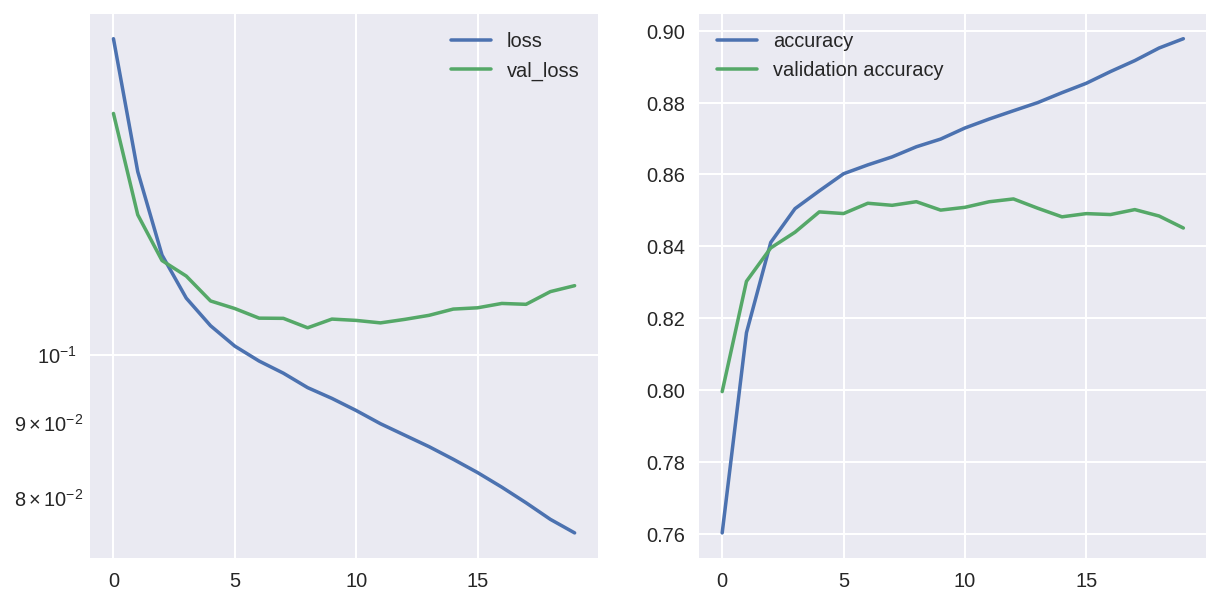

2021-02-25 10:48:49.281417: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


In [11]:
model = simple_model()
history = model.fit(x_train, y_train, 
                    epochs=20,
                    batch_size=2**9,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[PlotLearning()])

In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


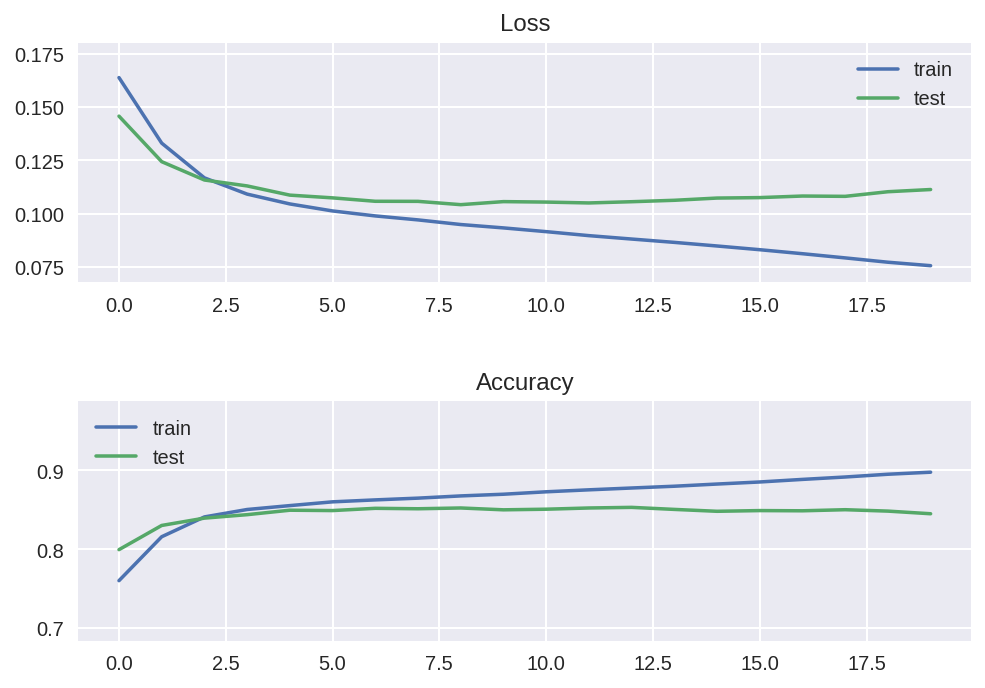

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
y_min = 0.9*min(min(history.history['loss']), min(history.history['val_loss']))
y_max = 1.1*max(max(history.history['loss']), max(history.history['val_loss']))
plt.ylim(y_min, y_max)
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.subplots_adjust(hspace=0.5)
y_min = 0.9*min(min(history.history['accuracy']), min(history.history['val_accuracy']))
y_max = 1.1*max(max(history.history['accuracy']), max(history.history['val_accuracy']))
plt.ylim(y_min, y_max)
plt.show()

In [15]:
x_signal_trans = scaler.transform(x_signal)

In [16]:
model.predict(np.array( [x_signal_trans[7],] ))

array([[0.86295074]], dtype=float32)

In [28]:
output_array1 = model.predict_proba(scaler.transform(x_sig_train))
output_array2 = model.predict_proba(scaler.transform(x_bkg_train))

output_array3 = model.predict_proba(scaler.transform(x_sig_test))
output_array4 = model.predict_proba(scaler.transform(x_bkg_test))

In [18]:
#print(model.evaluate(x_train, y_train))
#print(model.evaluate(x_test, y_test))
#print(model.evaluate(scaler.transform(x_signal), y_signal))
#print(model.evaluate(scaler.transform(x_bkg), y_bkg))

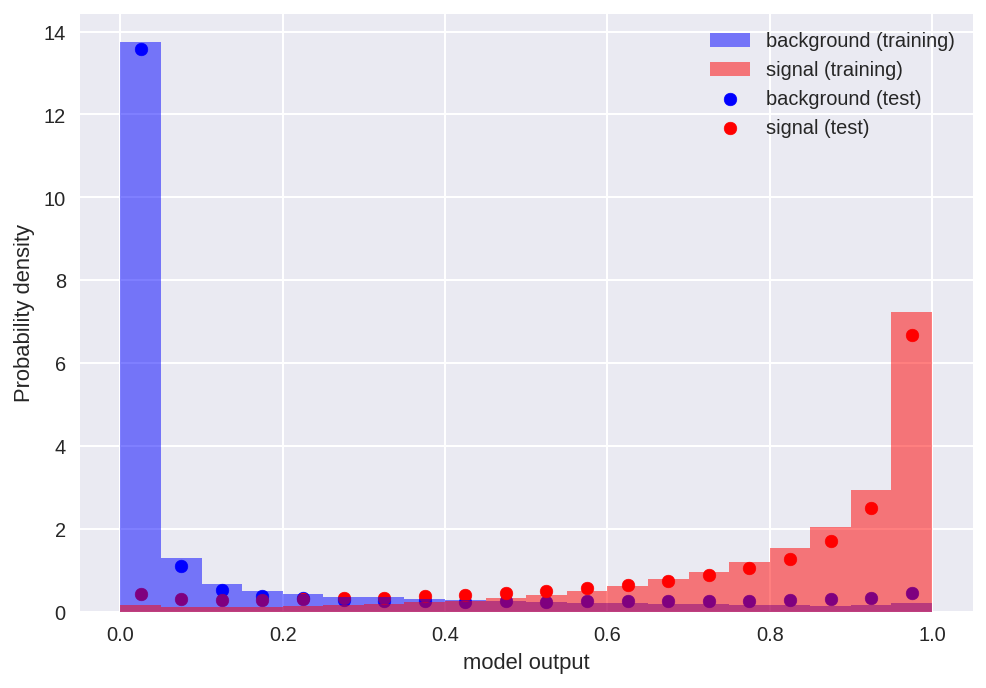

In [34]:
plt.style.use("seaborn")
fig, ax = plt.subplots()
n_bins = 20

y, bins, patches = ax.hist(output_array2, bins=n_bins, density=True, color='blue', alpha=0.5, label='background (training)')
y, bins, patches = ax.hist(output_array4, bins=n_bins, density=True, color='blue', alpha=0.0)
bin_centers = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
plt.scatter(bin_centers, y, marker='o', c='blue', s=40, alpha=1,  label='background (test)')

y, bins, patches = ax.hist(output_array1, bins=n_bins, density=True, color='red', alpha=0.5, label='signal (training)')
y, bins, patches = ax.hist(output_array3, bins=n_bins, density=True, color='red', alpha=0.0)
bin_centers = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
plt.scatter(0.5*(bins[1:] + bins[:-1]), y, marker='o', c='red', s=40, alpha=1, label='signal (test)')

ax.set_xlabel('model output')
ax.set_ylabel('Probability density')
ax.set_title("")
ax.legend()
#ax.set_yscale('log')

In [20]:
def get_signal_significance(xsec_sig, xsec_bkg, lumi, output_sig, output_bkg, thresholds):
    
    significance = []
    
    for threshold in thresholds:
        
        n_sig_expected = xsec_sig * lumi
        n_bkg_expected = xsec_bkg * lumi
        
        n_sig_pred_correct = len(output_sig[output_sig>threshold])
        n_sig_pred_wrong   = len(output_sig[output_sig<threshold])
        n_bkg_pred_correct = len(output_bkg[output_bkg<threshold])
        n_bkg_pred_wrong   = len(output_bkg[output_bkg>threshold])
        
        eff_sig = n_sig_pred_correct/len(output_sig)
        eff_bkg = n_bkg_pred_correct/len(output_bkg)
        
        n_sig = n_sig_expected * eff_sig
        n_bkg = n_bkg_expected * (1-eff_bkg)
        
        n_observed = n_sig + n_bkg
        
        if n_bkg > 0:
            sig = math.sqrt(2*n_observed*math.log(1+n_sig/n_bkg)-2*n_sig)
            #sig = n_sig/math.sqrt(n_sig+n_bkg)
        else:
            sig = 0
        
        print("threshold:", "{:.3f}".format(threshold), "\n"
              "eff_sig:", "{:.3f}".format(eff_sig),
              "eff_bkg:", "{:.3f}".format(eff_bkg),
              "n_sig:", "{:.0f}".format(n_sig), 
              "n_bkg:", "{:.0f}".format(n_bkg),
              "n_observed:", "{:.0f}".format(n_observed), "\n",
              "significance:", "{:.3f}".format(sig), "\n\n")
        
        significance.append(sig)    
        
    return thresholds, np.array(significance)

In [21]:
thresholds , significance = get_signal_significance(1, 1, 50000, output_array1, 
                                                    output_array2, np.arange(0.1, 1-1e-3, 1e-2))

threshold: 0.100 
eff_sig: 0.975 eff_bkg: 0.743 n_sig: 48761 n_bkg: 12854 n_observed: 61616 
 significance: 309.208 


threshold: 0.110 
eff_sig: 0.973 eff_bkg: 0.749 n_sig: 48661 n_bkg: 12540 n_observed: 61202 
 significance: 310.987 


threshold: 0.120 
eff_sig: 0.971 eff_bkg: 0.756 n_sig: 48572 n_bkg: 12178 n_observed: 60750 
 significance: 313.244 


threshold: 0.130 
eff_sig: 0.970 eff_bkg: 0.763 n_sig: 48477 n_bkg: 11836 n_observed: 60313 
 significance: 315.393 


threshold: 0.140 
eff_sig: 0.968 eff_bkg: 0.768 n_sig: 48381 n_bkg: 11601 n_observed: 59983 
 significance: 316.752 


threshold: 0.150 
eff_sig: 0.966 eff_bkg: 0.772 n_sig: 48289 n_bkg: 11376 n_observed: 59665 
 significance: 318.090 


threshold: 0.160 
eff_sig: 0.964 eff_bkg: 0.777 n_sig: 48195 n_bkg: 11150 n_observed: 59345 
 significance: 319.455 


threshold: 0.170 
eff_sig: 0.962 eff_bkg: 0.783 n_sig: 48092 n_bkg: 10875 n_observed: 58966 
 significance: 321.223 


threshold: 0.180 
eff_sig: 0.960 eff_bkg: 0.786 

 significance: 344.935 


threshold: 0.810 
eff_sig: 0.635 eff_bkg: 0.952 n_sig: 31731 n_bkg: 2399 n_observed: 34130 
 significance: 343.193 


threshold: 0.820 
eff_sig: 0.621 eff_bkg: 0.954 n_sig: 31058 n_bkg: 2293 n_observed: 33351 
 significance: 341.268 


threshold: 0.830 
eff_sig: 0.607 eff_bkg: 0.956 n_sig: 30358 n_bkg: 2187 n_observed: 32546 
 significance: 339.152 


threshold: 0.840 
eff_sig: 0.592 eff_bkg: 0.958 n_sig: 29621 n_bkg: 2081 n_observed: 31702 
 significance: 336.820 


threshold: 0.850 
eff_sig: 0.577 eff_bkg: 0.961 n_sig: 28857 n_bkg: 1974 n_observed: 30832 
 significance: 334.299 


threshold: 0.860 
eff_sig: 0.561 eff_bkg: 0.963 n_sig: 28030 n_bkg: 1867 n_observed: 29897 
 significance: 331.324 


threshold: 0.870 
eff_sig: 0.543 eff_bkg: 0.965 n_sig: 27145 n_bkg: 1764 n_observed: 28909 
 significance: 327.712 


threshold: 0.880 
eff_sig: 0.525 eff_bkg: 0.967 n_sig: 26237 n_bkg: 1645 n_observed: 27882 
 significance: 324.557 


threshold: 0.890 
eff_sig: 0.5

355.71877994289895


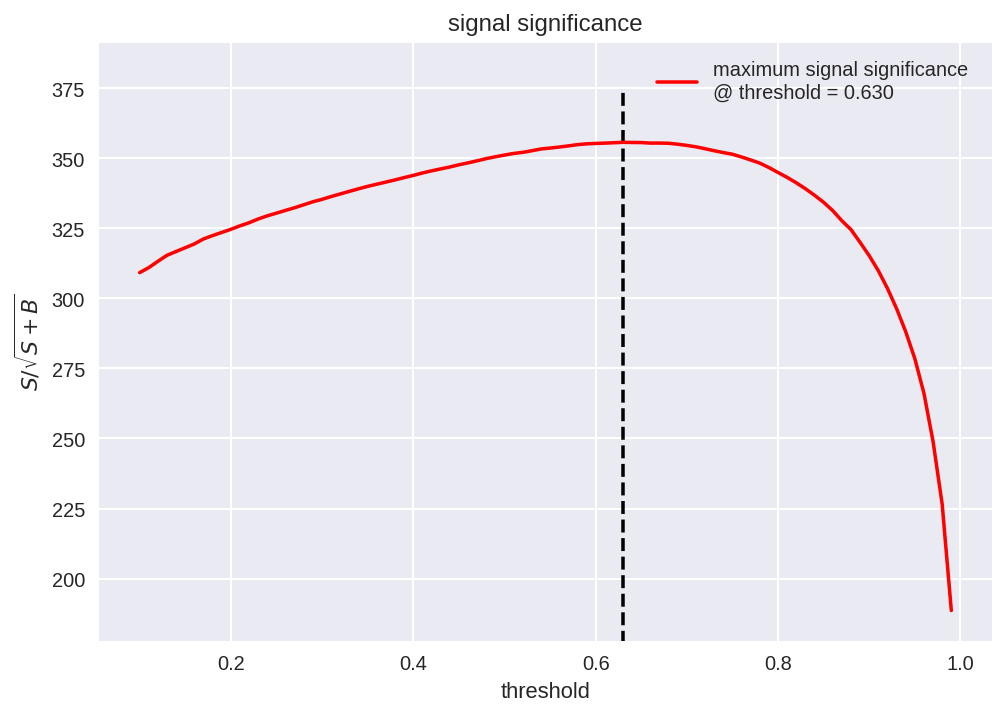

In [22]:
max_sig_threshold = thresholds[np.where(significance==max(significance))][0]
print(max(significance))
plt.figure(1)
plt.plot([max_sig_threshold, max_sig_threshold], [0, 1.05*max(significance)], 'k--')
plt.plot(thresholds, significance, label='maximum signal significance \n@ threshold = {:.3f}'.format(max_sig_threshold), color="red")
plt.xlabel('threshold')
plt.ylabel(r"$S/\sqrt{S+B}$")
plt.ylim([0.5*max(significance),1.1*max(significance)])
plt.title('signal significance')
plt.legend(loc="best")
plt.savefig("significance.pdf")

In [23]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

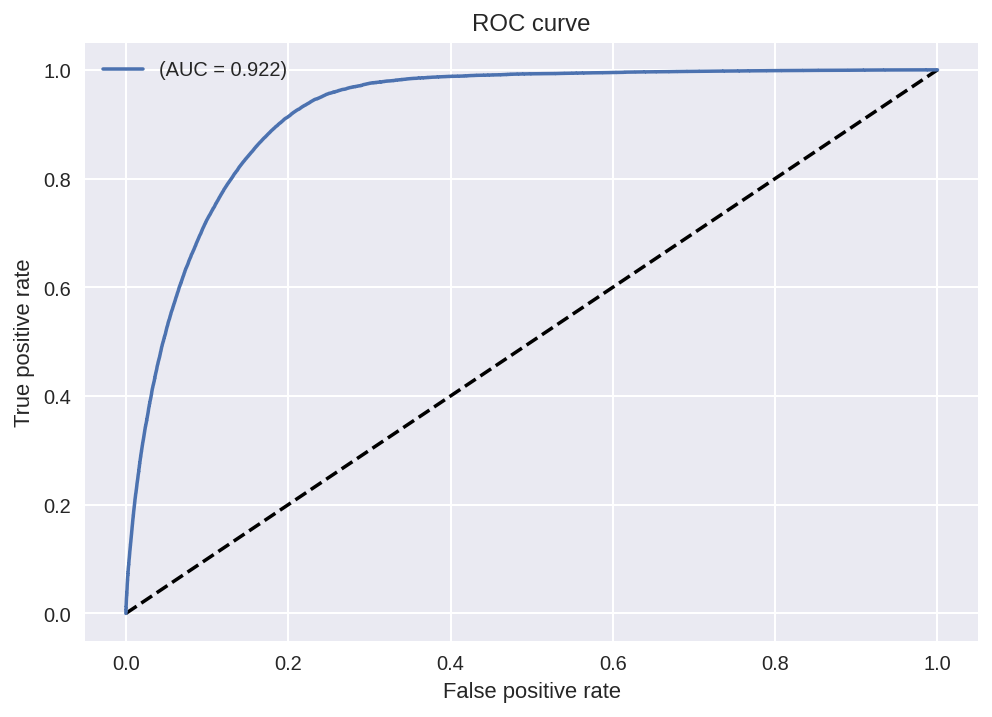

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras,tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()